<a href="https://colab.research.google.com/github/rythmm24/IR-Vector-space-model/blob/master/NLP_model_analysis_on_tweets_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6e6083d3-cfe9-62a2-4693-5d0537e2a0d1)


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-12 09:05:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-12 09:05:21 (34.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys


#Get Text dataset (Text samples of tweets)

In [6]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-06-12 09:07:01--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 142.250.81.208, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-06-12 09:07:01 (108 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [8]:
import pandas as pd #Visualizing data using pandas
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
6968,9994,tsunami,"Austin, TX",Dr. Jim &amp; the tsunami: The latest New York...,0
5433,7752,police,Indonesia,Police kill hatchet-wielding gunman who opened...,1
4940,7039,mayhem,Jersey Shore,BREAKING: Authorities respond to Ocean fire ht...,1
1924,2767,curfew,"Adelaide, Australia",INFO S. WND: 030/6. CLD: SCT014 BKN032. EXP IN...,0
5958,8509,screaming,Û¢OlderCandyBloomÛ¢,/ it's fine baby I was screaming at the TV x h...,0


In [17]:
train_df.target.value_counts()


0    4342
1    3271
Name: target, dtype: int64

In [18]:
#Splitting dataset into train and validation

In [19]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [20]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(6851, 6851, 762, 762)

In [21]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long should the output sequence of tokens be?
                                    pad_to_max_tokens=True)

In [22]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [23]:
text_vectorizer.adapt(train_sentences)


In [24]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[247,   3, 216,   4,  13, 672,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pada', 'pact', 'pacquiao', 'packåÊfor', 'packing']


In [26]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input

embedding

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [32]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")
baseline_preds = model_0.predict(val_sentences)

Our baseline model achieves an accuracy of: 78.35%


In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [33]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 78.34645669291339,
 'f1': 0.7751407496450567,
 'precision': 0.797874005400419,
 'recall': 0.7834645669291339}

In [34]:
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [35]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [36]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20210612-092751
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.6116 - accuracy: 0.6965 - val_loss: 0.5385 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4414 - accuracy: 0.8173 - val_loss: 0.4723 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3465 - accuracy: 0.8624 - val_loss: 0.4614 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2842 - accuracy: 0.8899 - val_loss: 0.4706 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2369 - accuracy: 0.9117 - val_loss: 0.4907 - val_accuracy: 0.7874


In [39]:
model_1.evaluate(val_sentences, val_labels)


24/24 [==============================] - 0s 3ms/step - loss: 0.4907 - accuracy: 0.7874


[0.4906875789165497, 0.787401556968689]

In [40]:
model_1_pred_probs = model_1.predict(val_sentences)

In [41]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions


In [42]:
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7847733477974695,
 'precision': 0.7881363675413527,
 'recall': 0.7874015748031497}

In [44]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)


(10000, 128)


In [45]:
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Model 2 LSTM

In [46]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [47]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210612-093746
Epoch 1/5
215/215 [==============================] - 9s 20ms/step - loss: 0.2183 - accuracy: 0.9212 - val_loss: 0.5806 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1555 - accuracy: 0.9442 - val_loss: 0.6693 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1287 - accuracy: 0.9530 - val_loss: 0.7300 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1091 - accuracy: 0.9580 - val_loss: 0.8072 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0882 - accuracy: 0.9664 - val_loss: 0.8355 - val_accuracy: 0.7415


In [49]:
model_2_pred_probs = model_2.predict(val_sentences)

In [50]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))


In [51]:

# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 74.1469816272966,
 'f1': 0.7415165302623242,
 'precision': 0.7415658112180421,
 'recall': 0.7414698162729659}

In [ ]:
#Model 3 GRU

In [52]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [53]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:

# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210612-093933
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.1584 - accuracy: 0.9409 - val_loss: 0.8234 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0865 - accuracy: 0.9692 - val_loss: 0.8297 - val_accuracy: 0.7493
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0753 - accuracy: 0.9720 - val_loss: 1.0905 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0657 - accuracy: 0.9720 - val_loss: 1.0499 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0559 - accuracy: 0.9753 - val_loss: 1.1500 - val_accuracy: 0.7612


In [55]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [56]:

# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.11548556430446,
 'f1': 0.7583711645164876,
 'precision': 0.7608541318962074,
 'recall': 0.7611548556430446}

In [58]:
#Model 4 Bi RNN

In [59]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [61]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [62]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20210612-094120
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.1074 - accuracy: 0.9679 - val_loss: 0.8636 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0574 - accuracy: 0.9764 - val_loss: 0.9534 - val_accuracy: 0.7520
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0468 - accuracy: 0.9790 - val_loss: 1.2129 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0432 - accuracy: 0.9812 - val_loss: 1.3550 - val_accuracy: 0.7520
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0394 - accuracy: 0.9822 - val_loss: 1.5003 - val_accuracy: 0.7454


In [63]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

In [64]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 74.54068241469817,
 'f1': 0.7435879394952223,
 'precision': 0.744133326363886,
 'recall': 0.7454068241469817}

In [65]:
#Model 5 Conv1D


In [ ]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

In [66]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [67]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210612-094324
Epoch 1/5
215/215 [==============================] - 30s 19ms/step - loss: 0.1336 - accuracy: 0.9626 - val_loss: 0.9228 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0751 - accuracy: 0.9724 - val_loss: 1.0762 - val_accuracy: 0.7297
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0632 - accuracy: 0.9766 - val_loss: 1.1760 - val_accuracy: 0.7297
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0549 - accuracy: 0.9778 - val_loss: 1.2413 - val_accuracy: 0.7310
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0522 - accuracy: 0.9775 - val_loss: 1.3125 - val_accuracy: 0.7139


In [68]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [69]:

# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)

In [71]:
#TensorFlow Hub Pretrained Sentence Encoder

In [70]:
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [72]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [73]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210612-094556
Epoch 1/5
215/215 [==============================] - 6s 18ms/step - loss: 0.5107 - accuracy: 0.7851 - val_loss: 0.4470 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4158 - accuracy: 0.8149 - val_loss: 0.4366 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4024 - accuracy: 0.8257 - val_loss: 0.4403 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3931 - accuracy: 0.8297 - val_loss: 0.4353 - val_accuracy: 0.7992
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3866 - accuracy: 0.8332 - val_loss: 0.4329 - val_accuracy: 0.8045


In [74]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))


In [75]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 80.4461942257218,
 'f1': 0.8034501592812708,
 'precision': 0.8039401905257199,
 'recall': 0.8044619422572179}

In [77]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,78.346457,0.797874,0.783465,0.775141
simple_dense,78.740157,0.788136,0.787402,0.784773
lstm,74.146982,0.741566,0.741470,0.741517
gru,76.115486,0.760854,0.761155,0.758371
bidirectional,74.540682,0.744133,0.745407,0.743588
conv1d,71.391076,0.713516,0.713911,0.713694
tf_hub_sentence_encoder,80.446194,0.803940,0.804462,0.803450


In [78]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100


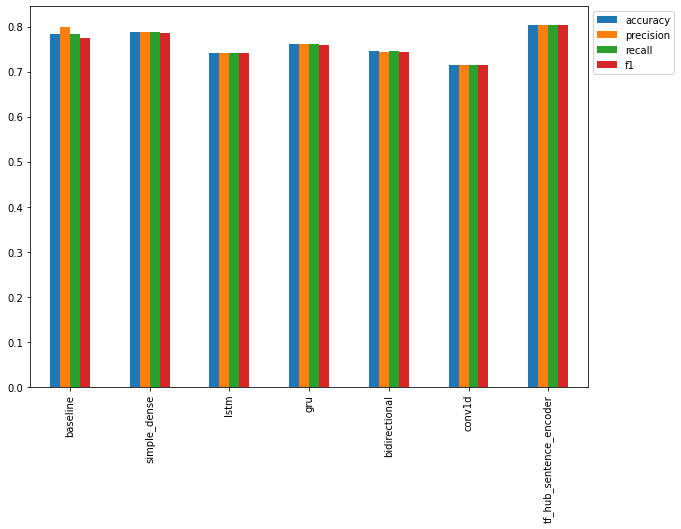

In [79]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


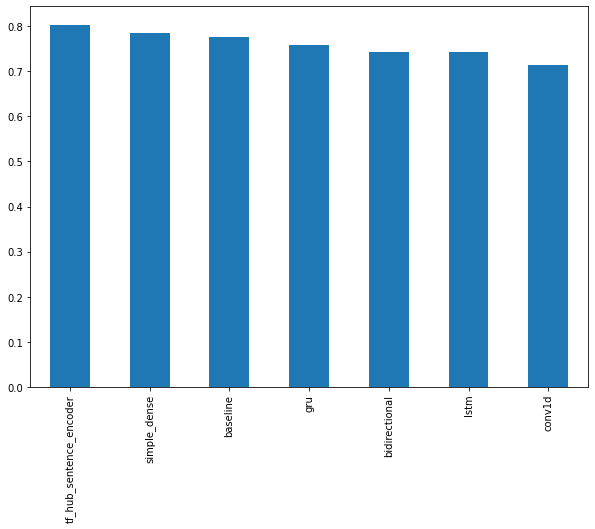

In [80]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));
